**Step 1: load the image and convert it to desired format**

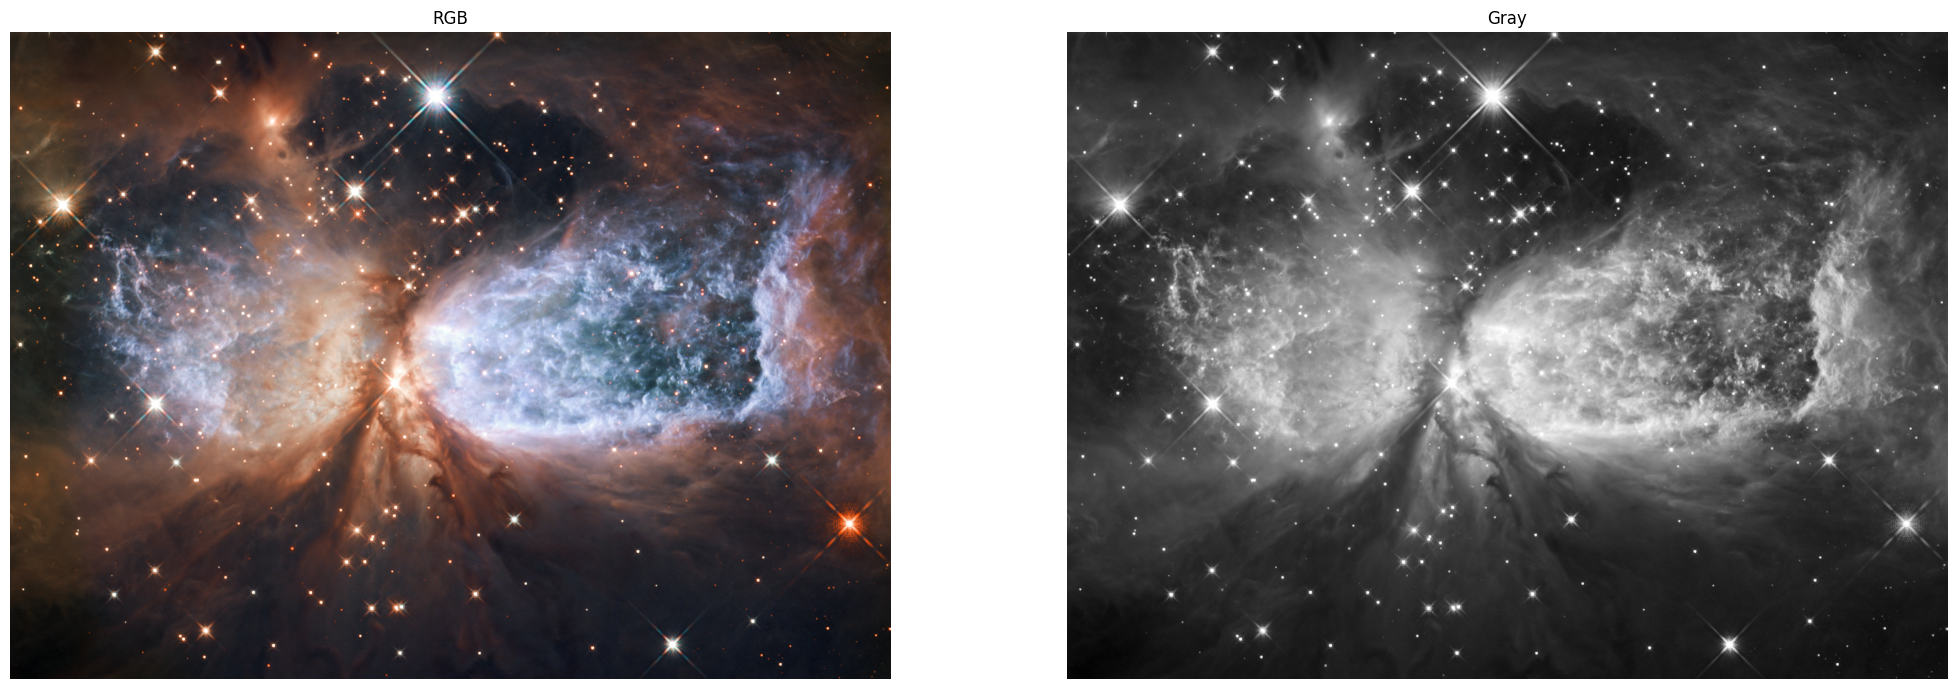

In [29]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


# Load the image
image = cv2.imread('heic1118a.tif', cv2.COLOR_BGR2RGB)

# Convert from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 2) Convert the RGB image to grayscale
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# Display
plt.figure(figsize=(25,20))
plt.subplot(1,2,1)
plt.title('RGB')
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Gray')
plt.imshow(image_gray, cmap='gray')
plt.axis('off')

plt.show()

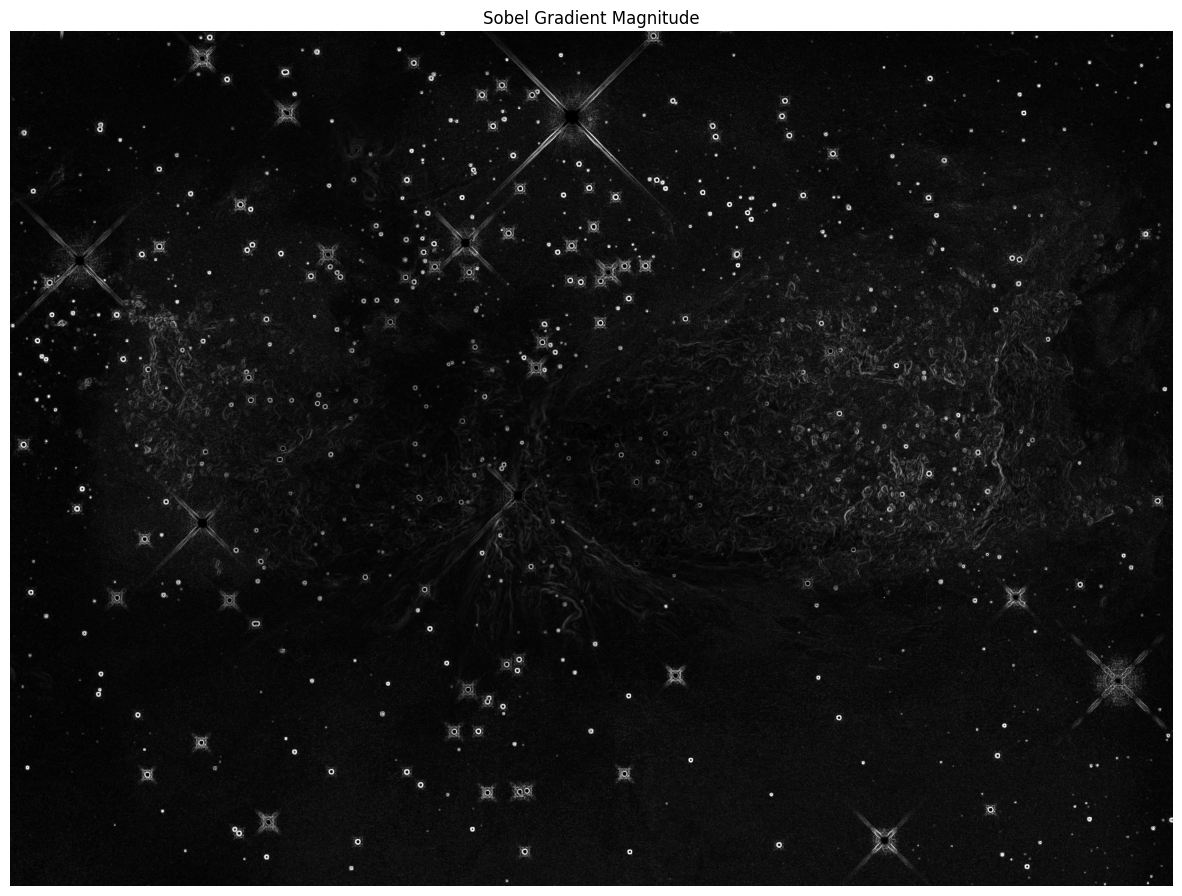

In [30]:
# Sobel gradient
sobel_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)
grad_mag = cv2.magnitude(sobel_x, sobel_y)
grad_mag = cv2.convertScaleAbs(grad_mag)

# Display the gradient magnitude
plt.figure(figsize=(15,15))
plt.imshow(grad_mag, cmap='gray')
plt.title('Sobel Gradient Magnitude')
plt.axis('off')
plt.show()

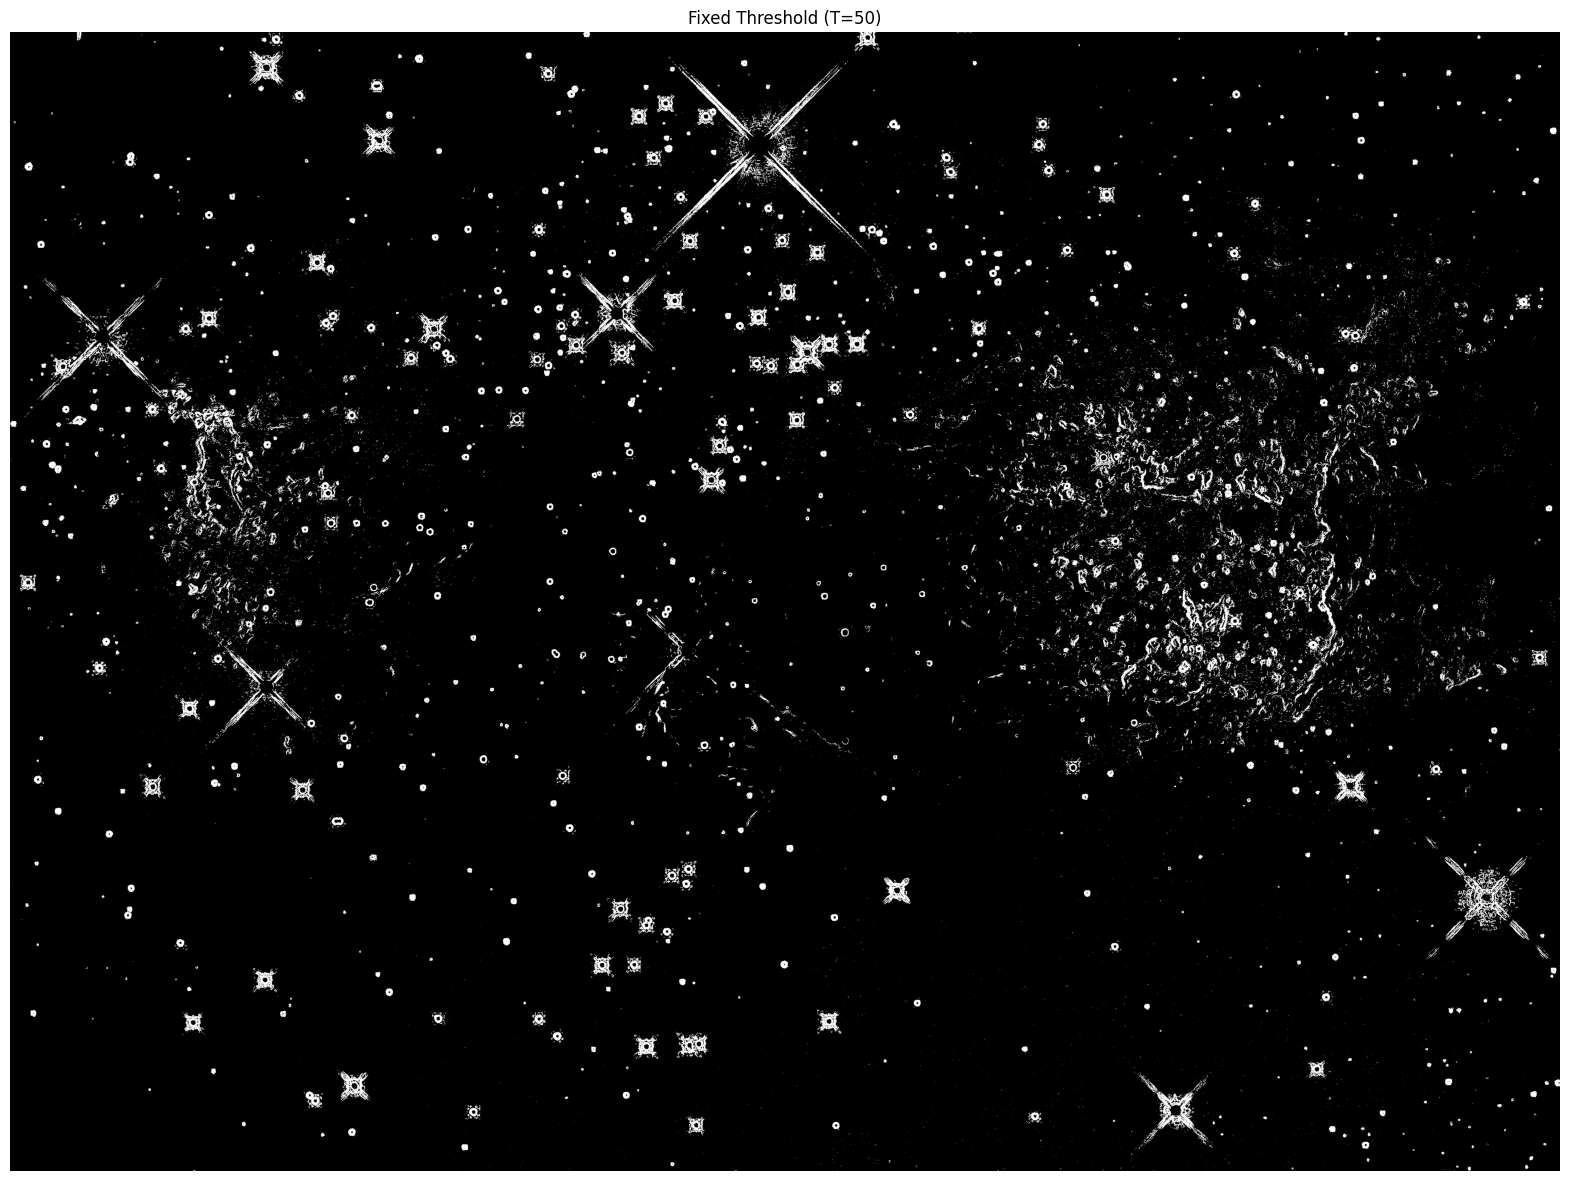

In [31]:
# T can be in [0,255]; you’ll need to tune
T = 50  
_, mask_fixed = cv2.threshold(grad_mag, T, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(20,20))
plt.imshow(mask_fixed, cmap='gray')
plt.title(f'Fixed Threshold (T={T})')
plt.axis('off')
plt.show()

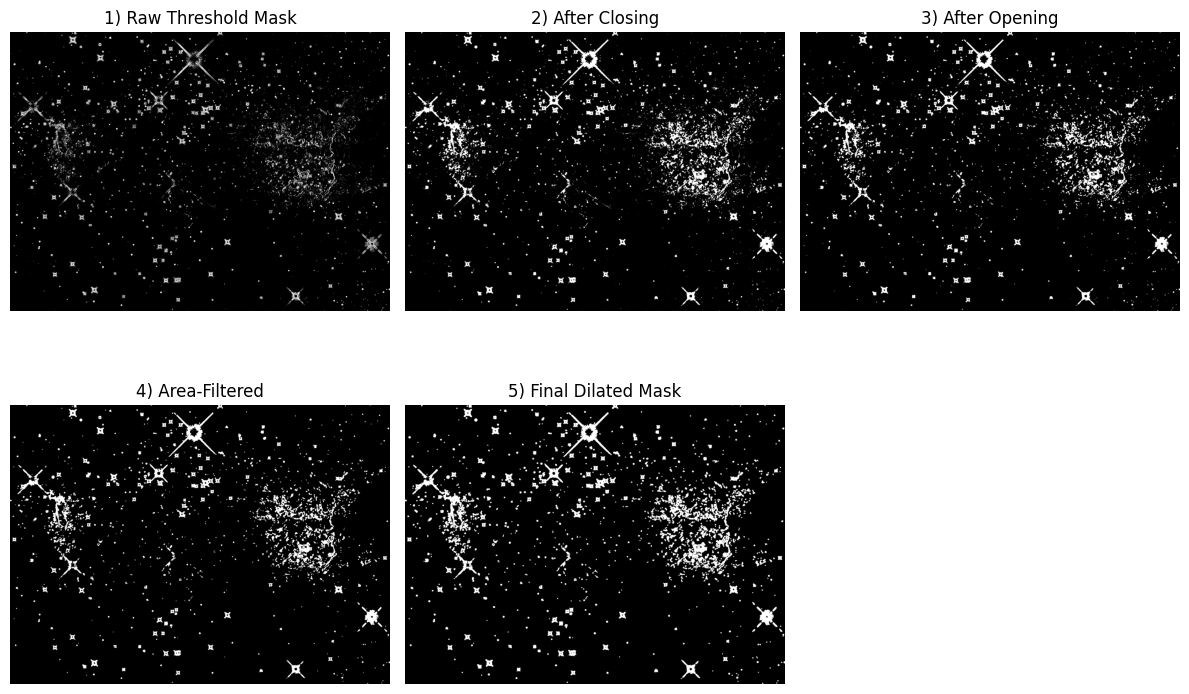

In [32]:
# 1) Create a small elliptical kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# 2) Morphological closing (dilate then erode) to fill in the hollow rings
mask_closed = cv2.morphologyEx(mask_fixed, cv2.MORPH_CLOSE, kernel, iterations=2)

# 3) Morphological opening (erode then dilate) to remove tiny speckles
mask_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel, iterations=1)

# 4) (Optional) Remove any remaining small components by area thresholding
#    This ensures noise dots smaller than, say, 50 pixels are thrown away.
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_opened, connectivity=8)
mask_area = np.zeros_like(mask_opened)
min_area = 50
for label in range(1, num_labels):
    if stats[label, cv2.CC_STAT_AREA] >= min_area:
        mask_area[labels == label] = 255

# 5) Final dilation to make sure each star blob fully covers the star + a small halo
mask_clean = cv2.dilate(mask_area, kernel, iterations=1)

# 6) Visualize each step
plt.figure(figsize=(12,8))
for i, (img, title) in enumerate([
    (mask_fixed,    '1) Raw Threshold Mask'),
    (mask_closed,   '2) After Closing'),
    (mask_opened,   '3) After Opening'),
    (mask_area,     '4) Area-Filtered'),
    (mask_clean,    '5) Final Dilated Mask'),
]):
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

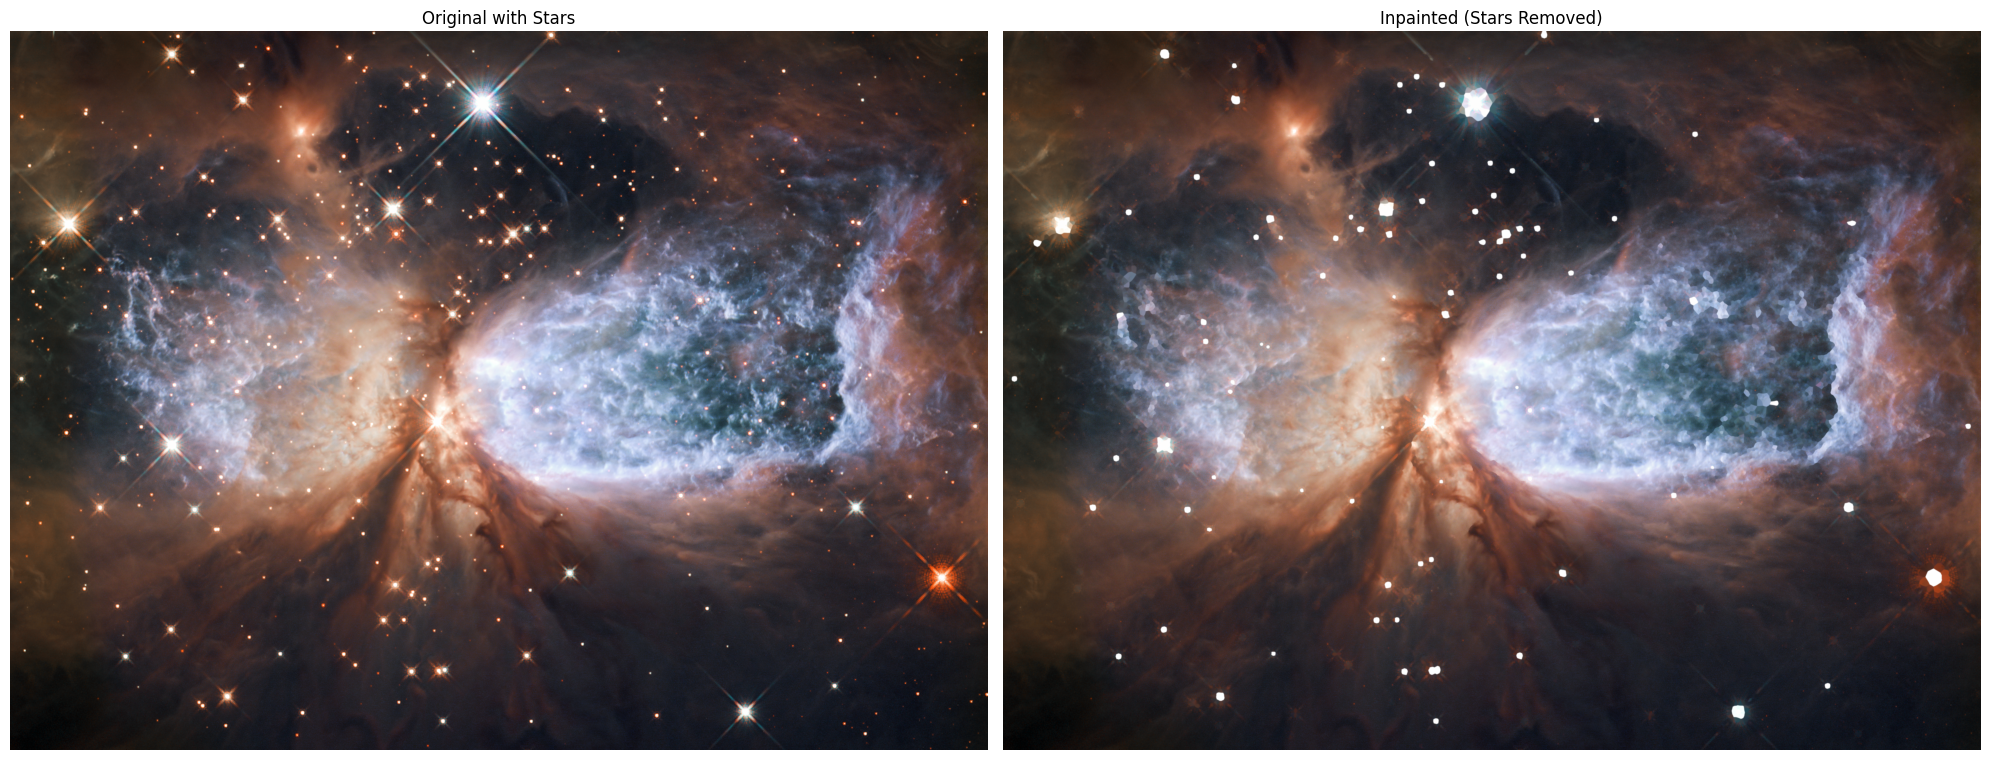

In [34]:
# image_rgb : your original color image (numpy array, uint8, shape H×W×3)
# mask_clean : your final mask (numpy array, uint8, shape H×W, values 0 or 255)

# Choose an inpainting algorithm:
#   - cv2.INPAINT_TELEA : a fast, patch-based method
#   - cv2.INPAINT_NS    : Navier–Stokes based, smoother but a bit slower
flags = cv2.INPAINT_TELEA

# Radius defines how far from each masked pixel the algorithm looks to interpolate
inpaint_radius = 3

# Perform inpainting
inpainted = cv2.inpaint(image_rgb, mask_clean, inpaint_radius, flags)

# Display original vs inpainted
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title("Original with Stars")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Inpainted (Stars Removed)")
plt.imshow(inpainted)
plt.axis("off")

plt.tight_layout()
plt.show()
